# Data Discovery

In [39]:
# These are the main includes used through the notebook
import datetime
import numpy as np                   # numeric linear algebra
import matplotlib.pyplot as plt      # plotting
import rasterio       # read/write geotiffs
import tsd            # time series downloader for sentinel and landsat
import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import folium
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import pandas as pd
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import itertools
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange

In [3]:
aoi_saclay = {"type":"Polygon","coordinates":[[[2.086544,48.711127],[2.086544,48.764676],[2.216663,48.764676],[2.216663,48.711127],[2.086544,48.711127]]]}
aoi_test_saclay = {"type":"Polygon","coordinates":[[[1.992645,48.708861],[1.992645,48.749398],[2.072296,48.749398],[2.072296,48.708861],[1.992645,48.708861]]]}
center = [2.146797,48.738984]

In [4]:
m = vistools.foliummap()

aoi = aoi_saclay
m.center = [2.146797,48.738984]
# add center field
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()

# draw the polygon and center map
folium.GeoJson(aoi).add_to(m)
folium.GeoJson(aoi_test_saclay).add_to(m)
m.location = aoi['center'][::-1]
display(m)

## Sentinel-2

In [15]:
start_date = datetime.datetime(2017, 6, 1)
end_date = date
time.datetime(2017, 1, 31)

# Run the query
image_catalog = tsd.get_sentinel2.search(aoi_saclay, start_date=start_date, end_date=end_date)
#image_catalog = tsd.get_landsat.search(aoi)

if len(image_catalog) == 0:
    print("Maybe your AOI selection is too large")

# There's plenty of data associated to each entry of the catalog.
# Take some time to see all the available keys of each image entry dict.
# Note that there is a cloud cover percentage estimation,
# and a thumbnail url
import pandas as pd
pd.DataFrame([dict(i) for i in image_catalog])

Found 12 images


,metadata_source,title,geometry,cloud_cover,thumbnail,aws_sequence_number,aws_id,source,mgrs_id,utm_zone,lat_band,sqid,epsg,date,relative_orbit,processing_level,satellite,filename,urls
0,stac,S2A_MSIL2A_20200101T105441_N0213_R051_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",96.74,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200101_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-01 10:54:41,51,2A,S2A,2020-01-01_S2A_orbit_051_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
1,stac,S2A_MSIL2A_20200104T110441_N0213_R094_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",78.98,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200104_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-04 11:04:41,94,2A,S2A,2020-01-04_S2A_orbit_094_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
2,stac,S2B_MSIL2A_20200106T105339_N0213_R051_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",0.10,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2B_31UDQ_20200106_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-06 10:53:39,51,2A,S2B,2020-01-06_S2B_orbit_051_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
3,stac,S2B_MSIL2A_20200109T110329_N0213_R094_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",96.01,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2B_31UDQ_20200109_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-09 11:03:29,94,2A,S2B,2020-01-09_S2B_orbit_094_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
4,stac,S2A_MSIL2A_20200111T105421_N0213_R051_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",94.43,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200111_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-11 10:54:21,51,2A,S2A,2020-01-11_S2A_orbit_051_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
5,stac,S2A_MSIL2A_20200114T110411_N0213_R094_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",100.00,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200114_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-14 11:04:11,94,2A,S2A,2020-01-14_S2A_orbit_094_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
6,stac,S2B_MSIL2A_20200116T105309_N0213_R051_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",1.68,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2B_31UDQ_20200116_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-16 10:53:09,51,2A,S2B,2020-01-16_S2B_orbit_051_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
7,stac,S2B_MSIL2A_20200119T110259_N0213_R094_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",0.17,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2B_31UDQ_20200119_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-19 11:02:59,94,2A,S2B,2020-01-19_S2B_orbit_094_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
8,stac,S2A_MSIL2A_20200121T105341_N0213_R051_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",4.16,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200121_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-21 10:53:41,51,2A,S2A,2020-01-21_S2A_orbit_051_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"
9,stac,S2A_MSIL2A_20200124T110331_N0213_R094_T31UDQ_2...,"{'type': 'Polygon', 'coordinates': [[[1.641559...",80.55,https://roda.sentinel-hub.com/sentinel-s2-l1c/...,0,S2A_31UDQ_20200124_0_L2A,https://earth-search.aws.element84.com/v0/coll...,31UDQ,31,U,DQ,32631,2020-01-24 11:03:31,94,2A,S2A,2020-01-24_S2A_orbit_094_tile_31UDQ_L2A,"{'aws': {}, 'gcloud': {}}"


In [5]:
def query_clear_sky(aoi, satellite='Sentinel-2', max_cloud_cover=30,
                    start_date=None, end_date=None):
    '''
    queries the devseed database for the aoi
    returns a filtered catalog with images with cloud
    cover of at most max_cloud_cover
    my_satellite:   'Landsat-8'  or 'Sentinel-2'
    '''
    # run a search
    if satellite == 'Sentinel-2':
        res = tsd.get_sentinel2.search(aoi, start_date, end_date)
    elif satellite == 'Landsat-8':
        res = tsd.get_landsat.search(aoi, start_date, end_date)


    ###### Insert your solution code here ######
    out = []
    for p in res:
        if p.cloud_cover < max_cloud_cover: out.append(p)

    return out

def get_crop_from_aoi(aoi, catalog_entry, band, output):
    """
    Crop and download an AOI from a georeferenced image.
    Args:
        output_path (string): path to the output GeoTIFF file
        aoi (geojson.Polygon): area of interest defined by a polygon in longitude, latitude coordinates
        catalog_entry (tsd.s2_metadata_parser.Sentinel2Image): metadata object
        band (str): desired band, e.g. 'B04' for Sentinel-2 or 'B8' for Landsat-8
    """
    
    metadata = catalog_entry
    if not metadata.urls['aws']:
        metadata.build_s3_links()
    inpath = metadata.urls['aws'][band]

    utm_zone = metadata.get("utm_zone")
    lat_band = metadata.get("lat_band")
    epsg = tsd.utils.utm_to_epsg_code(utm_zone, lat_band) if utm_zone else None

    ulx, uly, lrx, lry, epsg = tsd.utils.utm_bbx(aoi, epsg=epsg, r=60)
    
    date = str(metadata.get('date'))[:10]
    output_path = output +'/{}_sentinel-2_{}.tif'.format(date,band)
    print(output_path)
    tsd.utils.rasterio_geo_crop(output_path, inpath, ulx, uly, lrx, lry, epsg=epsg)
    

def compute_NDVI(im_b04, im_b08):
    ''' basefilename to store the bands:  basename+BAND+'.tif'
        returns a numpy array
    '''
    NDVI = (im_b08 - im_b04)/(im_b08 + im_b04)
    return NDVI   # NDVI image (numpy array)

def compute_NDWI(im_b03, im_b08):
    ''' basefilename to store the bands:  basename+BAND+'.tif'
        returns a numpy array
    '''
    NDWI = (im_b03 - im_b08)/(im_b08 + im_b03)
    return NDWI

def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''
    import numpy as np
    minimum, maximum = np.percentile(im, percentiles), np.percentile(im, 100 - percentiles)
    im = np.clip(im, minimum, maximum)
    im = 255*(im - minimum) / (maximum - minimum)

    return im.astype(np.uint8)   # return equalized image

def simple_color_radar(im_vh, im_vv, percentiles=5):
    '''
    Visualization of radar images
    '''
    im_tot = im_vh / im_vv
    
    out = [im_tot, im_vh, im_vv]
    
    im = np.squeeze(out,axis=(3)).transpose(1,2,0)
    im[:,:,0] = simple_equalization_8bit(im[:,:,0], percentiles)
    im[:,:,1] = simple_equalization_8bit(im[:,:,1], percentiles)
    im[:,:,2] = simple_equalization_8bit(im[:,:,2], percentiles)
    
    return im.astype(np.uint8)



In [250]:
start_date = datetime.datetime(2017, 6, 1)
end_date = datetime.datetime(2018, 1, 1)

# Let's start downloading the green channel
my_satellite, bandred, bandgreen, bandnir = 'Sentinel-2','B04','B03','B08'  # 'Landsat-8', 'B8' #

results = query_clear_sky(aoi_saclay, my_satellite, max_cloud_cover=10,
                          start_date=start_date, end_date=end_date)

results_df = pd.DataFrame([dict(i) for i in results])

Found 24 images


In [251]:
# This is where the downloading is done
for i in range(len(results)):
    for band in [bandred, bandgreen, bandnir]:
        get_crop_from_aoi(aoi_saclay, results[i], band, 'data_saclay/optic')

data_saclay/optic/2017-08-29_sentinel-2_B04.tif
data_saclay/optic/2017-08-29_sentinel-2_B03.tif
data_saclay/optic/2017-08-29_sentinel-2_B08.tif
data_saclay/optic/2017-11-07_sentinel-2_B04.tif
data_saclay/optic/2017-11-07_sentinel-2_B03.tif
data_saclay/optic/2017-11-07_sentinel-2_B08.tif


## Sentinel 1

In [ ]:
# GRD --> module / SRC --> complex
# We want GRD
# bands VV / VH / HH, les prendre toutes
# Certaines images n'ont pas toutes les bandes
# regarder si on a VV / VH ?

In [14]:
# Regarder si les images sont bien recalées
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2020, 3, 30)
image_catalog_radar = tsd.get_sentinel1.search(aoi_saclay, start_date=start_date, end_date=end_date)

"""def remove_no_VV_VH(x):
    if 'vv' in x['polarisations'] and 'vh' in x['polarisations']:
        return x
    else: print('No VV or VH polarisation')

radar_aoi_df = pd.DataFrame([dict(i) for i in image_catalog_radar])
radar_aoi_df_filt = radar_aoi_df[radar_aoi_df['product_type'] == 'GRD'].apply(remove_no_VV_VH, axis=1)

filtered_image = []
for i in range(radar_aoi_df_filt.shape[0]):
    filtered_image.append(dict(radar_aoi_df_filt.loc[i]))"""

tsd-default-user b3c5e714034282ea5c
Found 51 images


"def remove_no_VV_VH(x):\n    if 'vv' in x['polarisations'] and 'vh' in x['polarisations']:\n        return x\n    else: print('No VV or VH polarisation')\n\nradar_aoi_df = pd.DataFrame([dict(i) for i in image_catalog_radar])\nradar_aoi_df_filt = radar_aoi_df[radar_aoi_df['product_type'] == 'GRD'].apply(remove_no_VV_VH, axis=1)\n\nfiltered_image = []\nfor i in range(radar_aoi_df_filt.shape[0]):\n    filtered_image.append(dict(radar_aoi_df_filt.loc[i]))"

In [16]:
%env COPERNICUS_LOGIN=cohen
%env COPERNICUS_PASSWORD=1234567890AZERTYUI

tsd.get_sentinel1.download_crops(image_catalog_radar, 
                                 aoi_saclay, 
                                 mirror='aws', 
                                 out_dir='./data_saclay_test/radar', 
                                 parallel_downloads=1, 
                                 timeout=600)

env: COPERNICUS_LOGIN=cohen
env: COPERNICUS_PASSWORD=1234567890AZERTYUI
Building 51 aws download urls... 

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

## Verify that images are well aligned

In [17]:
# Read + tranform to 8-bit optical image
im_B03  = utils.readGTIFF("data_saclay/optic/2020-01-21_sentinel-2_B03.tif")
im_B08 = utils.readGTIFF("data_saclay/optic/2020-01-21_sentinel-2_B08.tif")
im_NDWI = get_sentinel2_NDWI(im_B03, im_B08)
im_B08_scaled = simple_equalization_8bit(im_B08)

#
im_vv = utils.readGTIFF("data_saclay/radar/2020-01-21_S1B_orbit_110_D_GRD_vh.tif")
im_vh = utils.readGTIFF("data_saclay/radar/2020-01-21_S1B_orbit_110_D_GRD_vv.tif")
im_radar = simple_color_radar(im_vh, im_vv, 3)

imgs = [im_B08_scaled, im_radar]

RasterioIOError: data_saclay/radar/2020-01-21_S1B_orbit_110_D_GRD_vh.tif: No such file or directory


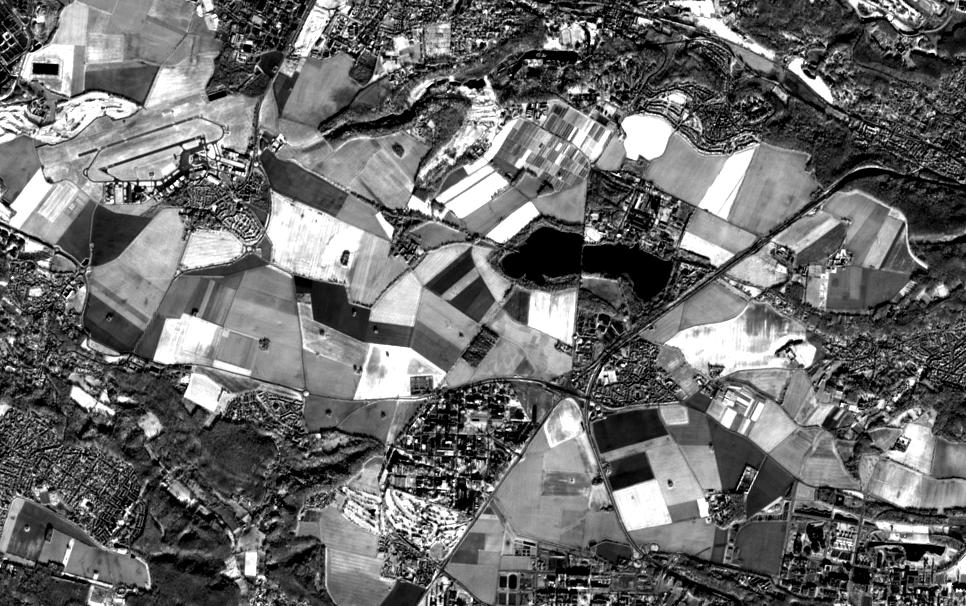
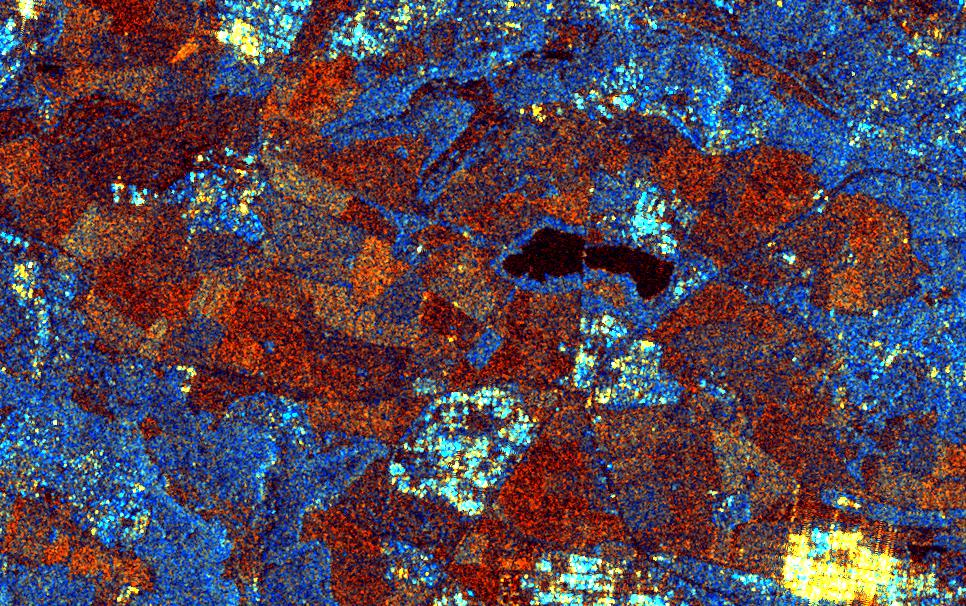

In [35]:
vistools.display_gallery(imgs)

In [69]:
im_radar_final.shape

(606, 966, 1)

In [70]:
im_optic_final.shape

(606, 966, 1)

In [27]:
im_radar.shape

(606, 966, 3)

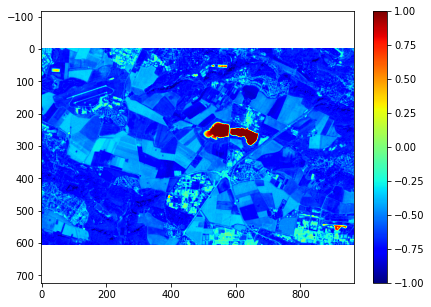

In [33]:
vistools.display_imshow(im_NDWI, [-1,1], cmap="jet")

## EVALUATION

- correlation coefficient

- Peak Signal to Noise Ratio (PSNR)
- Structural Similarity Measure (SSIM)
from skimage.measure import structural_similarity as ssim

In [6]:
def PSNR(original, compressed, L): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                   # Therefore PSNR have no importance. 
        return 100
    psnr = 20 * log10(L / sqrt(mse)) 
    return psnr

def correlation_coeff(im1, im2):
    return np.corrcoef(im1.reshape(-1), im2.reshape(-1))

from skimage.measure import structural_similarity as ssim
#ssim(im1, im2)


ImportError: cannot import name 'structural_similarity' from 'skimage.measure' (/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/skimage/measure/__init__.py)

## Baselines
### Interpolation

Consider that we have a set of optic information before the test set and after the end of the test. On possible mean to have the NVDI is to perform a simple linear interpolation.

In [7]:
def process_optic_image(path, group, type_):
    if type_ == 'NDWI':
        im_B03  = utils.readGTIFF(path + group[0])
        im_B08 = utils.readGTIFF(path + group[2])
        im = compute_NDWI(im_B03, im_B08)

    elif type_ == 'NDVI':
        im_B04  = utils.readGTIFF(path + group[1])
        im_B08 = utils.readGTIFF(path + group[2])
        im = compute_NDVI(im_B04, im_B08)
        
    return im

def load_and_process_optical(path, type_='NDVI'):
    """
    Loads all images in a specific folder, computes the NDVI or NDWI, transforms the images 
    into vectors (w*h) and stores it in a single array (rows: pixels, columns: images)
    
    INPUTS:
        - path: path where images are stored (bands B08, B03 for NDWI / bands B08, B04 for NDVI)
        - type_: wheter you want to perform NDVI or NDWI computation
        
    OUTPUT:
        - array of NDVI images (rows: pixels, columns: images)
        - size of the original images to be able to reshape afterwards
        
    IMPORTANT: 
    - You need to have the correct bands for all signals or the code will throw you an error
    - file names should have the following format: 'YYYY-MM-DD_xxxxxxx_B08.tif' as output 
    from Sentinel-2
    """
    
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files_grouped = [list(g) for _, g in itertools.groupby(sorted(files), lambda x: x.partition('_')[0])]
    
    for i, f in enumerate(files_grouped):
        im = process_optic_image(path, f, type_)
            
        if i == 0:
            shape = im.shape
            res = np.expand_dims(im.reshape(-1), axis=1)
        else:
            res = np.concatenate([res.copy(), np.expand_dims(im.reshape(-1), axis=1)], axis=1)
    
    return res, shape



def interpolation(x, y, x_int, kind='linear'):
    '''
    Perform a simple interpolation.
    See https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html for more details.
    
    INPUTS:
        - x: list or array of 
        - y: bi-dimensionnal array
        - x_int: float or array where you want to interpolate
        - kind: kind of interpolation you want (linear, cubic, quadratic)
    
    OUTPUTS:
        - y_int: vector or bi-dimensionnal array of interpolated values at x_int
        
    REMARKS: 
    In NDVI recovery, we are interested in interpolating NDVIs between different dates, so the x corresponds
    to the difference in time between different images and y is the NDVI images associated.
    '''
    f = interpolate.interp1d(x, y, kind=kind)
    y_int = f(x_int)
    
    return y_int
    
    
def interpolate_NDVI_NDWI(path, x, x_int, kind='linear', type_='NDVI'):
    """
    Interpolation or NDVI or NDWI
    """
    y, shape = load_and_process_optical(path, type_=type_)
    y_int = interpolation(x, y, x_int, kind=kind)
    
    return y_int.reshape(shape)

In [14]:
# In this example, the x-axis corresponds to months
path = './data_saclay_test/interpolation/'
type_ = 'NDVI'

x = [0,1,2,17,18,19,20]
x_int = 13

y_int = interpolate_NDVI_NDWI(path, x, x_int, kind='linear', type_='NDVI')

#### Evaluation

In [153]:
def correlation_coeff(im1, im2):
    return np.corrcoef(im1.reshape(-1), im2.reshape(-1))[0,1]

def get_avg_corr(im, res):
    avg_corr = 0
    for i in range(res.shape[1]):
        avg_corr += correlation_coeff(im, res[:,i])
    return avg_corr/res.shape[1]

path_test =  './data_saclay_test/optic/'
y_test, shape = load_and_process_optical(path_test, type_='NDVI')

In [16]:
get_avg_corr(y_int, y_test)

0.3984402997697196


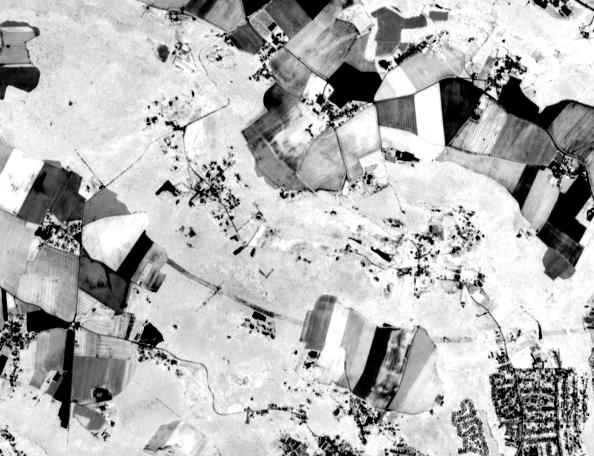
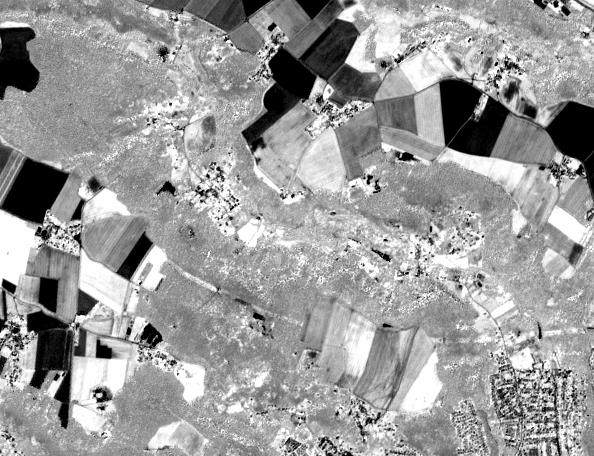

In [27]:
vistools.display_gallery([simple_equalization_8bit(y_int), simple_equalization_8bit(y_test[:,0].reshape(shape))])

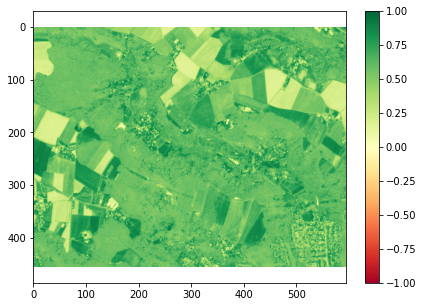

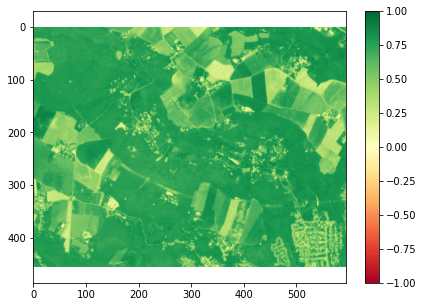

In [154]:
vistools.display_imshow(y_test[:,0].reshape(shape), [-1,1], cmap="RdYlGn")
vistools.display_imshow(y_int, [-1,1], cmap="RdYlGn")

In [152]:
y_test[:,0]

array([-0.66148532, -0.64003103, -0.64537941, ..., -0.57835821,
       -0.61172161, -0.60294118])

In [ ]:
# Show some predictions and their targets
# Read + tranform to 8-bit optical image
im_B03  = utils.readGTIFF("data_saclay/optic/2020-01-21_sentinel-2_B03.tif")
im_B08 = utils.readGTIFF("data_saclay/optic/2020-01-21_sentinel-2_B08.tif")
im_NDWI = get_sentinel2_NDWI(im_B03, im_B08)
im_B08_scaled = simple_equalization_8bit(im_B08)

#
im_vv = utils.readGTIFF("data_saclay/radar/2020-01-21_S1B_orbit_110_D_GRD_vh.tif")
im_vh = utils.readGTIFF("data_saclay/radar/2020-01-21_S1B_orbit_110_D_GRD_vv.tif")
im_radar = simple_color_radar(im_vh, im_vv, 3)

imgs = [im_B08_scaled, im_radar]

### Non Temporal Linear Regression (SAR --> NDVI)

In [175]:
# For this function you should have a folder with the 3 bands for all images, 
# otherwise it will throw an error

def group_paths(path_folder):
    """
    Group the different paths by date, in a sorted way. Dates are YYYY-MM-DD as
    the output from Sentinel-1 and Sentinel-2.
    
    INPUT:
        - path_folder: path of the folder in which you want to list the files
    
    OUTPUT:
        - tuple of :
            1. list of all files, 
            2. list of list of all files, with files grouped
    """
    files = sorted([f for f in listdir(path_folder) if isfile(join(path_folder, f))])
    files_grouped = [list(g) for _, g in itertools.groupby(sorted(files), lambda x: x.partition('_')[0])]
    
    return files, files_grouped


def compute_features(im_vv, im_vh, patch_size):
    """
    Compute the features array with pixel value and neighbors with a given patch size
    
    INPUT:
        - im_vv: image output by Sentinel-1 with VV band
        - im_vh: image output by Sentinel-1 with VH band
        - patch_size: number of neighbors you want to consider (patch_size=3 --> 8 neighbors ; patch_size=5 --> 24 neighbors)
    
    OUTPUT:
        - features array with both im_vv, im_vh features for all pixels (nb of rows = im_vv.shape[0]*im_vv.shape[1])
    """
    assert im_vv.shape == im_vh.shape, 'shapes are not aligned'
    
    if patch_size == 0:
        features_vv = np.expand_dims(im_vv.reshape(-1), axis=1)
        features_vh = np.expand_dims(im_vh.reshape(-1), axis=1)
        features = np.concatenate([features_vv, features_vh], axis = 1)
        
        return features
        
    n = patch_size  # neighborhood size
    h, w, d = im_vv.shape
    s = im_vv.strides

    tmp_vv = np.lib.stride_tricks.as_strided(im_vv, strides=s[:2] + s,
                                          shape=(h - n + 1, w - n + 1, n, n, d))
    tmp_vh = np.lib.stride_tricks.as_strided(im_vh, strides=s[:2] + s,
                                          shape=(h - n + 1, w - n + 1, n, n, d))
    features_vv = tmp_vv.reshape(-1, n**2 * d)
    features_vh = tmp_vh.reshape(-1, n**2 * d)
    features = np.concatenate([features_vv, features_vh], axis = 1)
    
    return features
    

def regression_NDVI_NDWI_fit(path_train_X, path_train_y, model=SGDRegressor(max_iter=1000, tol=1e-3, fit_intercept=True), patch_size=3,  type_='NDVI', log=False, scale=True):
    """
    
    """
    a = int((patch_size-1)/2)
    _, files_radar_grouped = group_paths(path_train_X)
    files_optic, files_optic_grouped = group_paths(path_train_y)
    dates_optic = [datetime.datetime.strptime(f[:10],'%Y-%m-%d') for f in files_optic]
    
    for i in trange(len(files_radar_grouped)): 

        file = files_radar_grouped[i]
        im_vh = utils.readGTIFF(path_train_radar + file[0])
        im_vv = utils.readGTIFF(path_train_radar + file[1])

        # find closest optic image and associate the NDVI / NDWI as index
        date_radar = datetime.datetime.strptime(file[0][:10],'%Y-%m-%d')
        diff_dates = [np.abs((date - date_radar)).days for date in dates_optic]
        optic_list = files_optic_grouped[np.argmin(diff_dates)%3]
        im_optic = process_optic_image(path_train_y, optic_list, type_)

        features = compute_features(im_vv, im_vh, patch_size)

        if scale == True:
            scaler = StandardScaler().fit(features)
            X = scaler.transform(features)
        else:
            X = features

        # We need to remove
        if patch_size >0: y = im_optic[a:-a,a:-a].reshape(-1)
        else: y = im_optic.reshape(-1)
        
        # train
        model.partial_fit(X, y)

    return model
    

    
def regression_NDVI_NDWI_transform(path_test, model, patch_size=3,  type_='NDVI', log=False, scale=True):
    Y = []
    _, files_radar_grouped = group_paths(path_test)

    for i in trange(len(files_radar_grouped)): 
        file = files_radar_grouped[i]
        im_vh = utils.readGTIFF(path_test + file[0])
        im_vv = utils.readGTIFF(path_test + file[1])

        features = compute_features(im_vv, im_vh, patch_size)

        if scale == True:
            scaler = StandardScaler().fit(features)
            X = scaler.transform(features)
        else:
            X = features
            
        y_pred = model.predict(X)
        if patch_size > 0 :
            y_pred = y_pred.reshape(im_vv.shape[0] - patch_size + 1, im_vv.shape[1] - patch_size + 1)
        else:
            y_pred = y_pred.reshape(im_vv.shape[0], im_vv.shape[1])
        
        ww, hh = im_vv.shape[0], im_vv.shape[1]
        color = y_pred.mean()
        result = np.full((ww,hh), color)

        # compute center offset
        xx = (ww - y_pred.shape[0]) // 2
        yy = (hh - y_pred.shape[1]) // 2

        # copy img image into center of result image
        result[yy:yy+y_pred.shape[0], xx:xx+y_pred.shape[1]] = y_pred


        Y.append(result)
        
    return np.array(Y)

In [180]:
#train the model
path_train_radar =  './data_saclay/radar/'
path_train_optic = './data_saclay/optic/'

model = regression_NDVI_NDWI_fit(path_train_radar, 
                             path_train_optic, 
                             model=SGDRegressor(max_iter=1000, tol=1e-3, fit_intercept=True),
                             patch_size=3,  
                             type_='NDVI', 
                             log=False,
                             scale=True)

  0%|          | 0/407 [00:00<?, ?it/s]

In [181]:
path_test = './data_saclay_test/optic/'
Y_pred = regression_NDVI_NDWI_transform(path_test,
                                        model, 
                                        patch_size=3,  
                                        type_='NDVI', 
                                        log=False, 
                                        scale=True)

  0%|          | 0/8 [00:00<?, ?it/s]

### Evaluation

In [182]:
y_test, shape = load_and_process_optical(path_test, type_='NDVI')


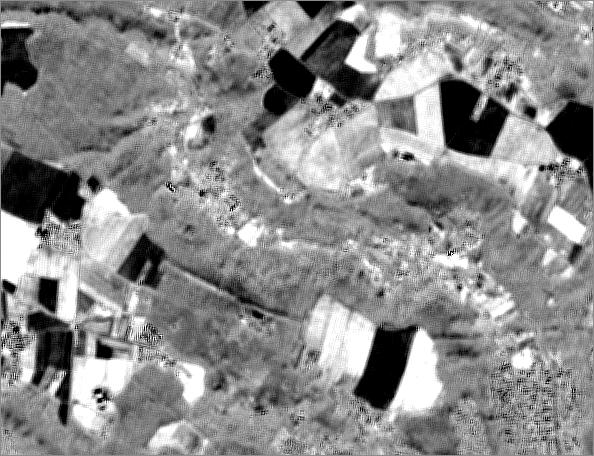
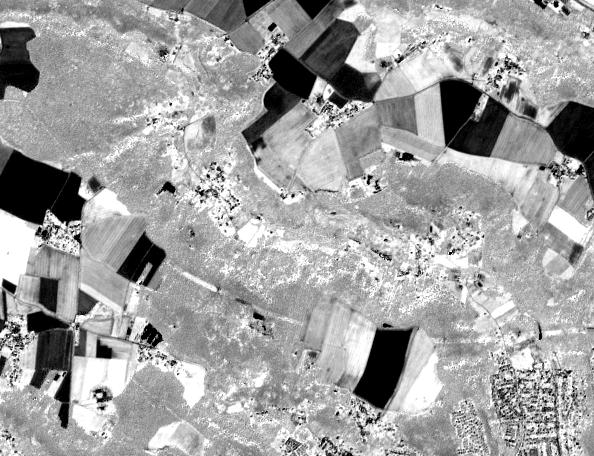

In [183]:
vistools.display_gallery([simple_equalization_8bit(Y_pred[1,:,:]), simple_equalization_8bit(y_test[:,1].reshape(shape))])

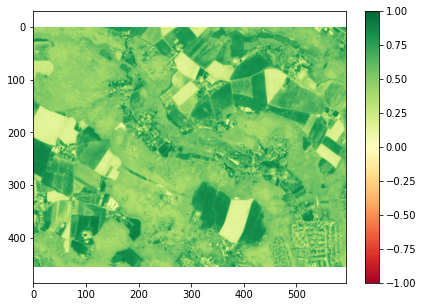

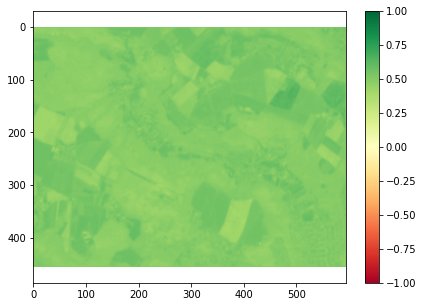

In [186]:
vistools.display_imshow(y_test[:,5].reshape(shape), [-1,1], cmap="RdYlGn")
vistools.display_imshow(Y_pred[5,:,:], [-1,1], cmap="RdYlGn")

## Deep learning Approach

### Non Temporal Approach (only SAR)

### Temporal Approach (a Pair before)

### Temporal Approach (a Pair before and a Pair after)